# GlassID - 1.D Cement Comparision

In [1]:
import numpy as np
from scipy import *
from scipy import sparse
from scipy.sparse.linalg import spsolve
from matplotlib.pyplot import *
from skimage import io
import h5py
from Data_Core.experiment import *
from Data_Core.digital_twin import *
from Data_Core.visual_interface import standard_analysis
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy import signal

In [2]:
def read_data_map(file):

    hf = h5py.File(file , 'r')
    sample = file.split("\\")[-1]
    keys = [key for key in hf.keys()]
    sample = keys[0].split(' ')[-1]

    spectrums = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['Shot_0']['raw_spectrum'][:,:-2]))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    positions = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['position']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    wavelengths = np.array(hf['System properties']['wavelengths'][:,:-2])
        
    unique_x = np.unique(positions[:,0])
    unique_y = np.unique(positions[:,1])
    
    nx = len(unique_x)
    ny = len(unique_y)
    indexes = np.lexsort((positions[:, 0],positions[:, 1]))
    spectrums = spectrums[indexes, :]
    spectrums = np.array(spectrums.reshape((ny, nx, -1)))
    # print(spectrums.shape)
    positions = np.array(positions[indexes])
    

    hf.close()
    return spectrums, wavelengths, positions, unique_x, unique_y

def read_data_map_pro(file):

    hf = h5py.File(file , 'r')
    sample = file.split("\\")[-1]
    keys = [key for key in hf.keys()]
    sample = keys[0].split(' ')[-1]

    positions = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['position']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    wavelengths = np.array(hf['System properties']['wavelengths'][:,:-2])
        
    unique_x = np.unique(positions[:,0])
    unique_y = np.unique(positions[:,1])
    
    nx = len(unique_x)
    ny = len(unique_y)
    indexes = np.lexsort((positions[:, 0],positions[:, 1]))
    positions = np.array(positions[indexes])
    
    
    pro_data = np.array(hf['pro_data'])    
    pro_data_norm = np.array(hf['pro_data_norm'])

    hf.close()
    
    return pro_data, pro_data_norm, wavelengths, positions, unique_x, unique_y

This notebook contains the data analysis for the workpackage related with cement analysis.

Experimental Data Reports to the Data acquired in 12/2/2024 of 5 datasamples:

<img title="Dataset 1b_Run1" alt="Alt text" src="Datasets_1_Run1/datasets_1B.png">

# 0. Preprocess data

The preprocessing stage is an essential task in a LIBS analysis pipeline to mitigate the effects of:
- Unwanted background radiation related with Bremsstrahlung effect;
- Plasma volume variation due to sample height, matrix effects, roughness and absorption;
- Plasma formation in air;

Taking this into consideration, and the final problem, we will preprocess the data using two strategies namely:
1. Baseline Removal using assymetric least squares method;
2. Signal normalization: normalization to the sum;

## 0.1. Optimization of Baseline Removal

In [3]:
def baseline_als_optimized(y, lam, p, niter = 10):
    L = len(y)
    D = sparse.diags([1, -2, 1],[0, -1, -2], shape = (L, L - 2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

## 0.2. Optimization of normalization strategy

In [4]:
##optimize parameters
lam = 1e2
p = 1e-4

## 0.3 Launch Parallel preprocessing strategy

In [5]:
folder = r'E:/Data/Data_LIBS/Vidros/'

samples = [{'Sample Name':'Zr1', 'data':'Zircao1.h5'},
           {'Sample Name':'Zr2', 'data':'Zircao2.h5'}]

Preprocess= True

for i in range(0,len(samples)):
    print(i, ' of ', len(samples), samples[i]['Sample Name'])
    file_read = folder + samples[i]['data']
    spectrum, wavelengths, positions, unique_x, unique_y = read_data_map(file_read)

    
    if Preprocess:
        pro_data = 1*np.array(spectrum)
        pro_data_norm = 1*np.array(spectrum)
        for i in tqdm(range(0, pro_data.shape[0])):
            for j in range(0, pro_data.shape[1]):
                spec = 1 * pro_data[i, j, :]
                pro_data[i, j, :] = spec - baseline_als_optimized(spec, lam = lam, p = p, niter = 10)
                pro_data_norm[i, j, :] =  pro_data[i, j, :] / (np.sum(pro_data[i, j, :]))

        with h5py.File(file_read , 'r+') as hf:
            try:
                hf['pro_data'] = np.array(pro_data,dtype=np.single)
                hf['pro_data_norm'] = np.array(pro_data_norm,dtype=np.single)
            except:
                data = hf['pro_data']     
                data[...] = np.array(pro_data, dtype = np.single)

                data1 = hf['pro_data_norm']     
                data1[...] = np.array(pro_data_norm, dtype = np.single)


0  of  2 Zr1


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


1  of  2 Zr2


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


## 0.4 Auxiliary - Find Elements Automatic

In [6]:
def find_wavelength_index(center_wavelength, wavelengths):
    """
    Find the index corresponding to the wavelength in wavelenghts that is 
    the closest to a given center_wavelength
    """
    return np.argmin(np.abs(wavelengths - center_wavelength), axis = 0)

def probable_element(lista):
    if len(lista) >= 3:
        return 1
    elif len(lista) >= 1:
        return 0.5
    elif len(lista) < 1:
        return 0
       
def classification_line(value):
    if value>0.05 and value<0.3:
        return "Low Intensity"
    elif value>=0.3 and value<0.5:
        return "Medium Intensity"
    elif value>=0.5 and value<=1:
        return "High Intensity"
    elif value>=0.0 and value<0.05:
        return "Ultra low Intensity"
    else:
        return "NA"
    
def element_lines(element, lower_limit = 250, upper_limit = 800, ion_num = 1):
    df = pd.read_csv("d_lines.txt", sep = ';')
    df['Line'] = [round(f, 2) for f in df['Line']]
    df.sort_values(by = ['Line','Relative Intensity'], ascending = [True, False], inplace = True)
    df1 = df[df['Relative Intensity'] > 0.01]
    df1 = df1[df1['Line'] > lower_limit]
    df1 = df1[df1['Line'] < upper_limit]
    df0 = df1.copy(deep = True)
    df0['Relative Intensity'] = [round(f, 3) for f in df1['Relative Intensity']]
    df0['Class'] = [classification_line(f) for f in df1['Relative Intensity']]
    df3 = df0[(df0["Element"] == element)]
    df4 = df3.sort_values(by = ['Relative Intensity'], ascending = [False])
    df4 = df4[df4['Ion'] == ion_num]
    return df4.to_numpy()

def find_element(element, spectrum, wave, nlines = 5, lower_limit = 250, upper_limit = 800, dh = 1, dh1 = 0.4, ion_num = 1, peak_prominence = 0.002):
    """
    Pick the most interesting emission lines for each element and deploys peak detection 
    around a specified regions of the spectrum.
    Then it check if the peak found is within a reasonable distance from expected peak.
    If so peak was found (state = 1) otherwise (state = 0)
    Checks if 1 or more peaks were found for that specified element.

    Returns probability of having that element, list of peaks that correspond to elements
    we are looking for, and unidentified peaks
    """
    most_relevant = np.array(element_lines(element, lower_limit, upper_limit, ion_num)[:nlines])
    most_relevant_peaks = most_relevant[:, 2]
    
    int_l = []
    spectrum = spectrum/np.max(spectrum)
    
    all_peaks_found = []
    peaks_not_found = []
    for i in range(0, len(most_relevant_peaks)):
        wave_right = find_wavelength_index(most_relevant_peaks[i] + dh, wave) 
        wave_left = find_wavelength_index(most_relevant_peaks[i]  - dh, wave)
        index_peaks_found, props = signal.find_peaks(spectrum[wave_left:wave_right], prominence = peak_prominence)
        peaks_found = wave[wave_left:wave_right][index_peaks_found]
        state = 0 #not found
        for j in range(0, len(peaks_found)):
            if ((peaks_found[j] + dh1) > most_relevant_peaks[i]) & ((peaks_found[j] - dh1) < most_relevant_peaks[i]):
                state = 1 #found
                if i not in int_l:
                    all_peaks_found.append(np.array([i, peaks_found[j]]))
                    int_l.append(i)
        if state == 0:
            peaks_not_found.append(np.array([i, most_relevant_peaks[i]]))
    print(element, int_l)
                

    prediction = probable_element(int_l)
    peaks = []
    
    if prediction == 1 or prediction == 0.5:
        peaks = all_peaks_found
            
    return prediction, np.array(peaks), np.array(peaks_not_found)

## 1. S1_UV Analysis

In [8]:
folder = r'E:/Data/Data_LIBS/Vidros/'

samples = [{'Sample Name':'Zr1', 'data':'Zircao1.h5'},
           {'Sample Name':'Zr2', 'data':'Zircao2.h5'}]

index_dataset = 0
print('Currently Analysing: ', samples[index_dataset]['Sample Name'])
file_read = folder + samples[index_dataset]['data']
pro_data, pro_data_norm, wavelengths, positions, unique_x, unique_y = read_data_map_pro(file_read)
wavel = wavelengths.flatten()
# image_path = folder + samples[index_dataset]['image']
# image_var = io.imread(image_path)

Currently Analysing:  Zr1


Glass: 70-73% SiO2, 12-13% Na2O, 0.5% K2O, 11% CaO, 1%MnO, 1.4% Al2O3, 0.3% Fe2O3, 0.06% Cr2O3

UV: FeO, Cromite de Ferro, C

White: ZnSe, CoO2

Amber: FeO, C

## 1.1 Spectral Zone Selection

In [9]:
dataset = pro_data

mean_signal = np.mean(dataset, axis = (0, 1))
min_signal = np.min(dataset, axis = (0, 1))
max_signal = np.max(dataset, axis = (0, 1))

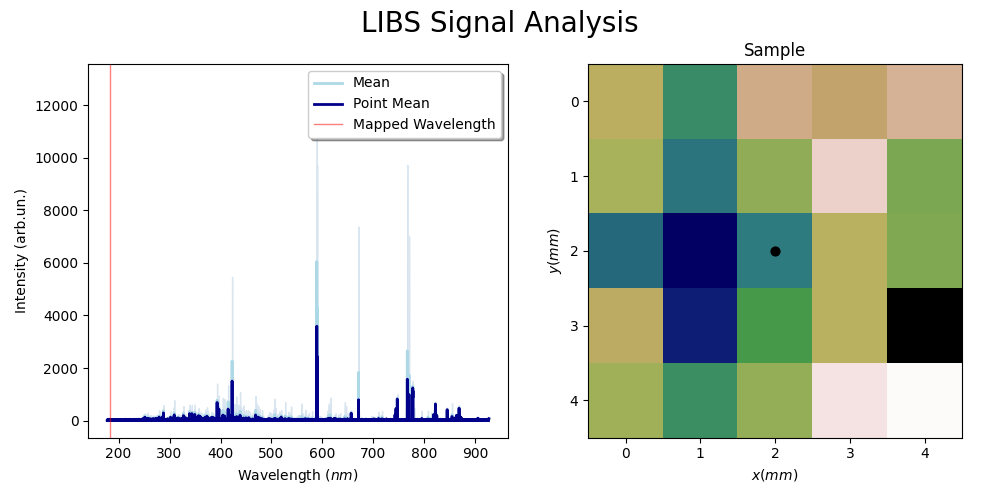

In [10]:
%matplotlib widget
standard_analysis(dataset, wavel)

In [25]:
samples = [{'Sample Name':'Cimento_XRF', 'data':'cimento_c_post.h5'},
           {'Sample Name':'Cimento_Ganulado', 'data':'cimento_s_post.h5'}]

for i in range(len(samples)):
    index_dataset = i
    print('############################################################')
    print('Currently Analysing: ', samples[index_dataset]['Sample Name'])
    file_read = folder + samples[index_dataset]['data']
    pro_data, pro_data_norm, wavelengths, positions, unique_x, unique_y = read_data_map_pro(file_read)
    wavel = wavelengths.flatten()

    data_meadian = np.median(pro_data_norm, axis = (0, 1))
    data_min = np.min(pro_data_norm, axis = (0, 1))
    data_max = np.max(pro_data_norm, axis = (0, 1))

    np.savetxt('E:/Data/Data_LIBS/Vidros/Areias/Additional Files/' + samples[index_dataset]['Sample Name'] + '.np', np.array([data_meadian, data_min, data_max]))

############################################################
Currently Analysing:  Cimento_XRF
############################################################
Currently Analysing:  Cimento_Ganulado


In [26]:
directory = 'E:/Data/Data_LIBS/Vidros/Areias/Additional Files/'
cpost, cpost_min, cpost_max = np.loadtxt(directory + 'Cimento_XRF.np')
spost, spost_min, spost_max = np.loadtxt(directory + 'Cimento_Ganulado.np')

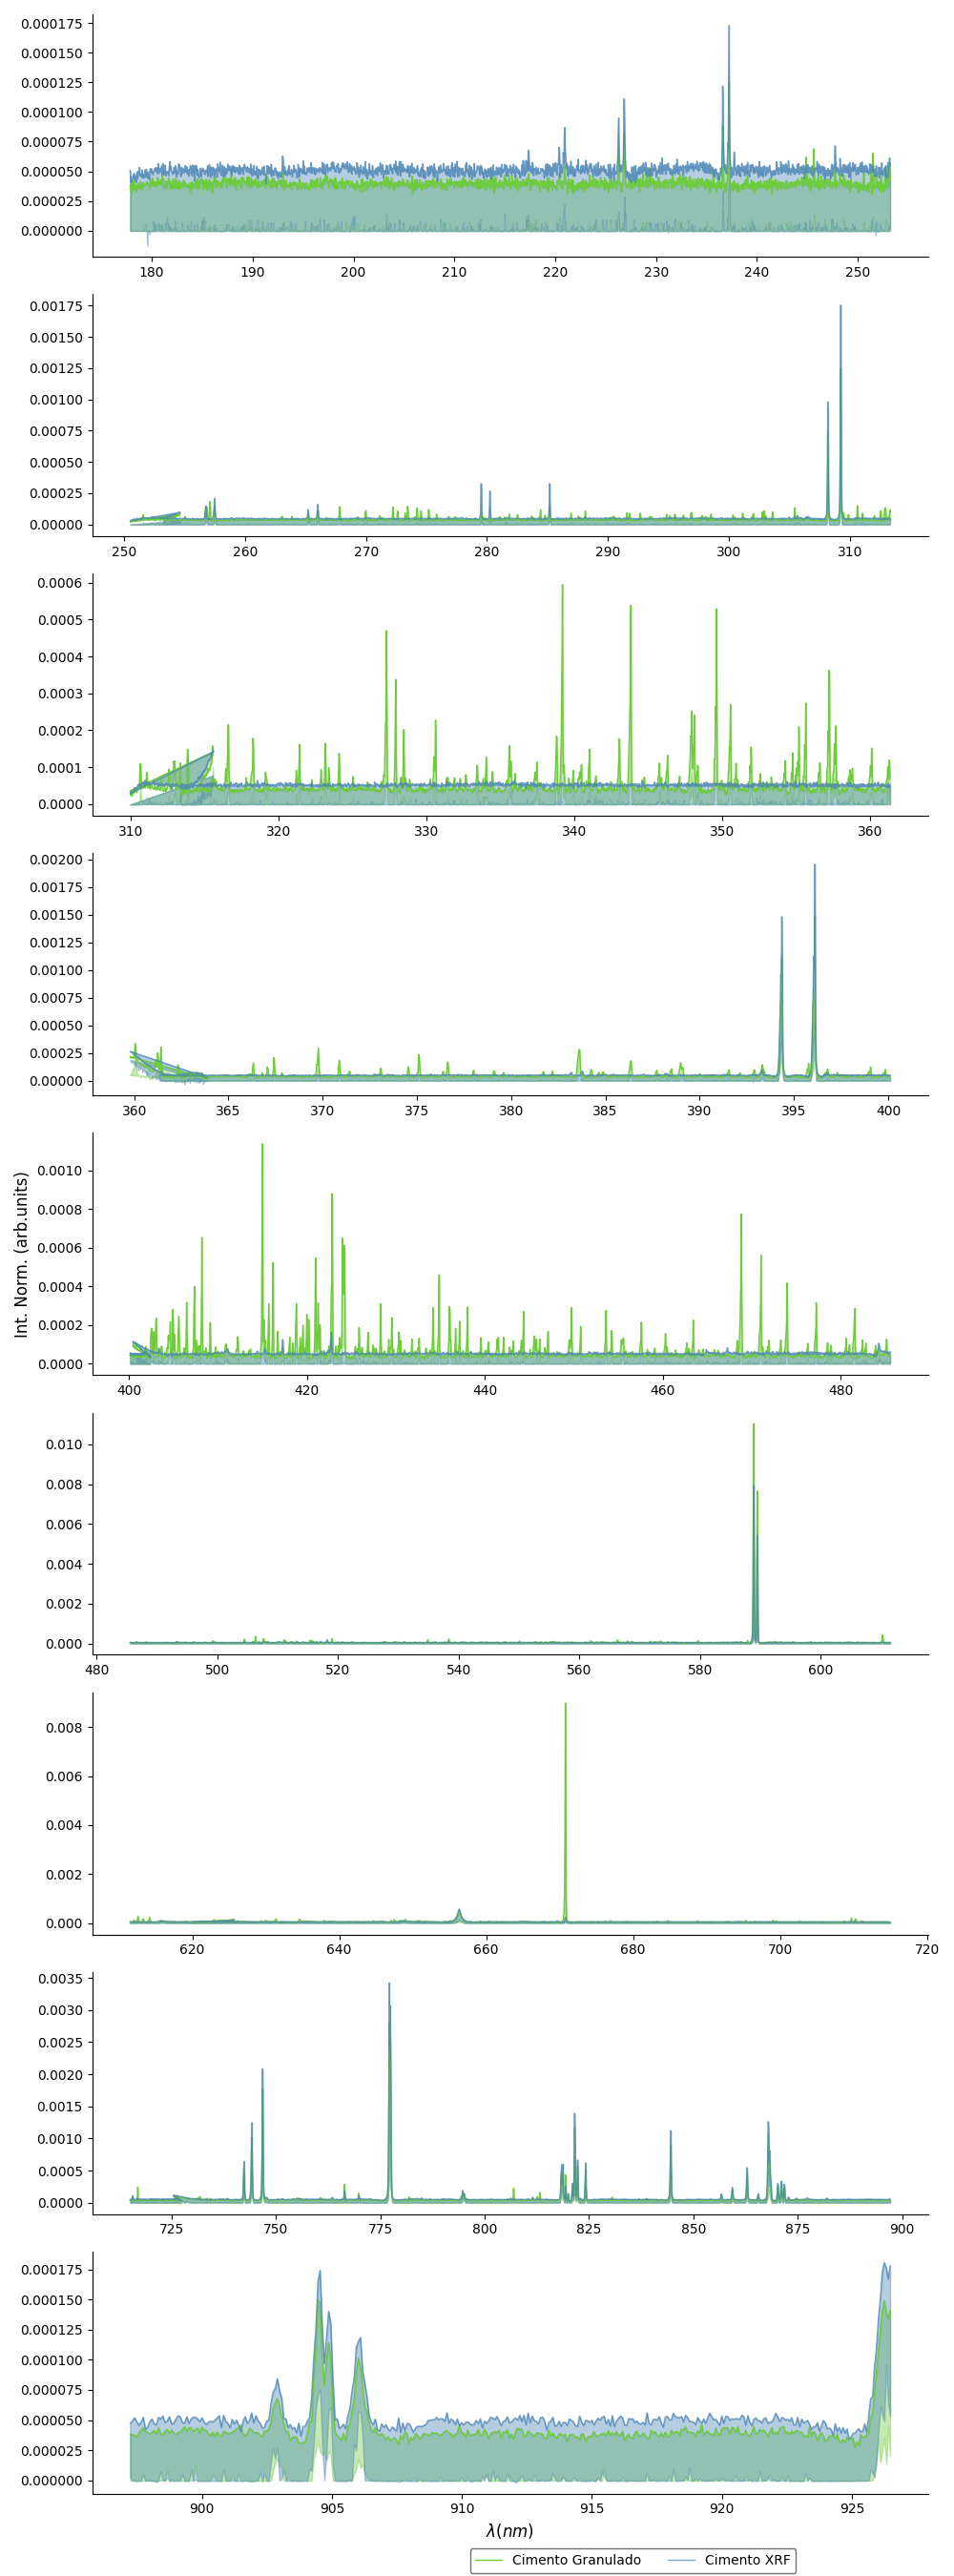

In [28]:
step = 2000
fig, axs = plt.subplots(int(len(wavel)/step+1), 1, figsize = [10, 3*int(len(wavel)/step+1)])

for i in range(0, len(wavel), step):
    ax = axs[i//step]

    ax.plot(wavel[i:i+step], spost[i:i+step], ls = '-', color = 'xkcd:apple', lw = 1, label = 'Cimento Granulado')
    ax.fill_between(wavel[i:i+step], spost[i:i+step], spost_min[i:i+step], ls = '-', color = 'xkcd:apple', alpha = 0.4)
    
    ax.plot(wavel[i : i+step], cpost[i : i+step], ls = '-', color = 'steelblue', lw = 1, label = 'Cimento XRF', alpha = 0.7)
    ax.fill_between(wavel[i : i+step], cpost[i : i+step], cpost_min[i : i+step], ls = '-', color = 'steelblue', alpha = 0.4)

    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax.set_xlabel(r'$\lambda (nm)$',fontsize = 12)
axs[4].set_ylabel(r'Int. Norm. (arb.units)', fontsize = 12)
axs[-1].legend(loc='upper right', bbox_to_anchor = (0.85, -0.2), edgecolor = '0.3', ncol = len(samples))
fig.tight_layout()
# savefig('E:/Data/Data_LIBS/Vidros/Areias/Images/Cimentos_spectra.jpg', dpi = 300)

## 1.2 Seek Elements of Interest

#############################################
Current Sample:Cimento XRF
Al [0, 1, 2, 3, 4]
Zn []
Ga [1, 3]
Ca [0]
Fe []
Fe []
Mg [0, 1, 2, 4]
Cr []
Si []
Al 	 ['396.05 nm', '309.25 nm', '394.3 nm', '308.17 nm', '257.48 nm']
Ga 	 ['417.26 nm', '403.35 nm']
Ca 	 ['422.72 nm']
Mg 	 ['285.18 nm', '383.79 nm', '383.17 nm', '518.22 nm']
#############################################
Current Sample:Cimento Granulado
Al [0, 1, 2, 3, 4]
Zn [0, 1, 2, 4]
Ga [1, 2]
Ca [0, 1, 2, 3]
Fe [3]
Fe []
Mg [0, 4]
Cr [3, 4]
Si [1]
Al 	 ['396.05 nm', '309.25 nm', '394.3 nm', '308.17 nm', '257.48 nm']
Zn 	 ['334.46 nm', '330.25 nm', '328.28 nm', '330.25 nm']
Ga 	 ['417.21 nm', '287.56 nm']
Ca 	 ['422.82 nm', '430.32 nm', '445.54 nm', '643.95 nm']
Mg 	 ['285.18 nm', '518.22 nm']
Cr 	 ['302.01 nm', '425.43 nm']
Si 	 ['288.13 nm']


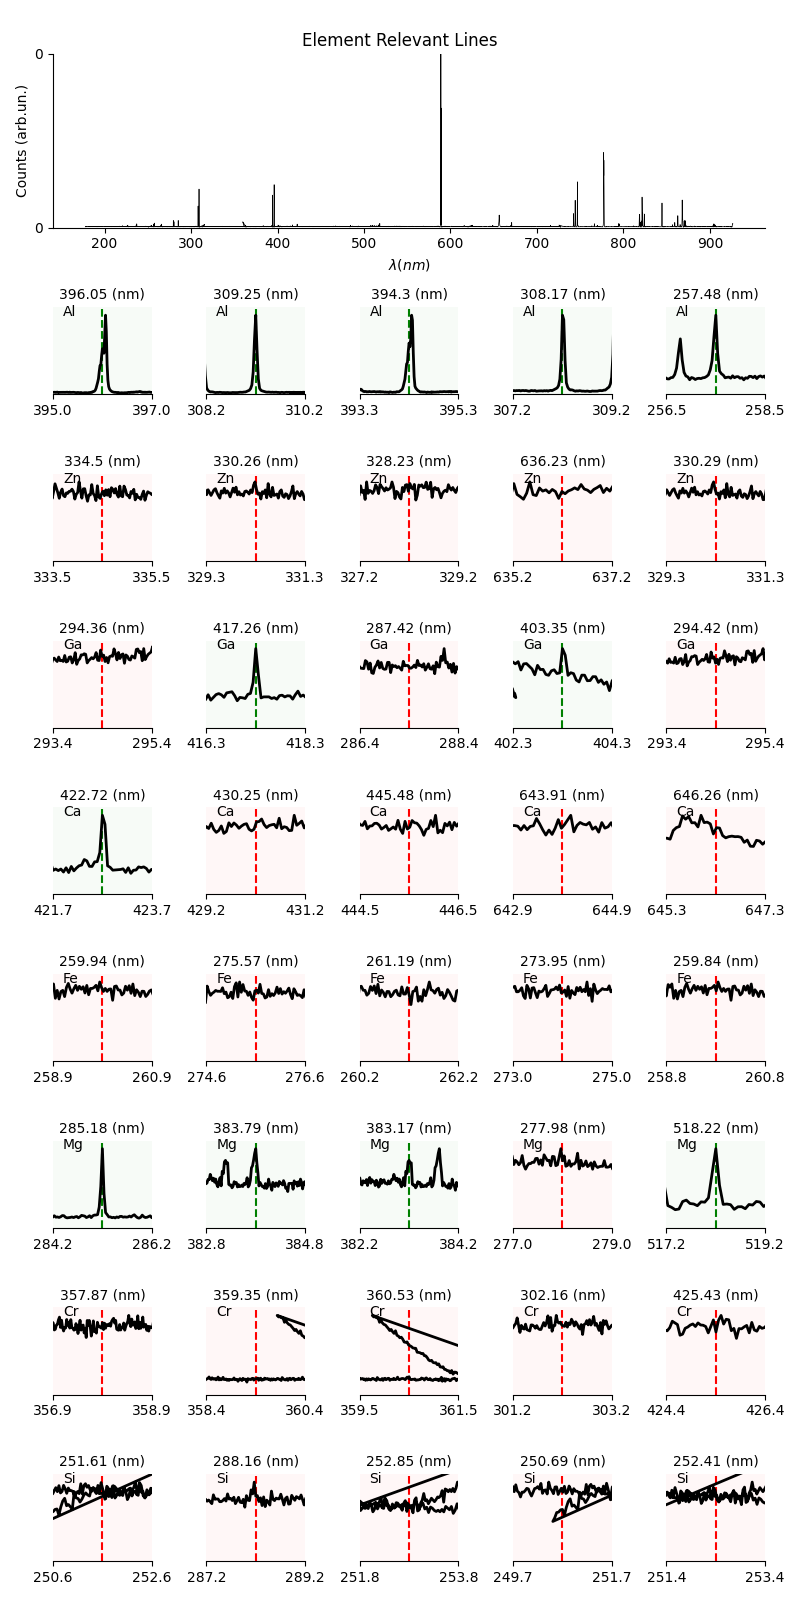

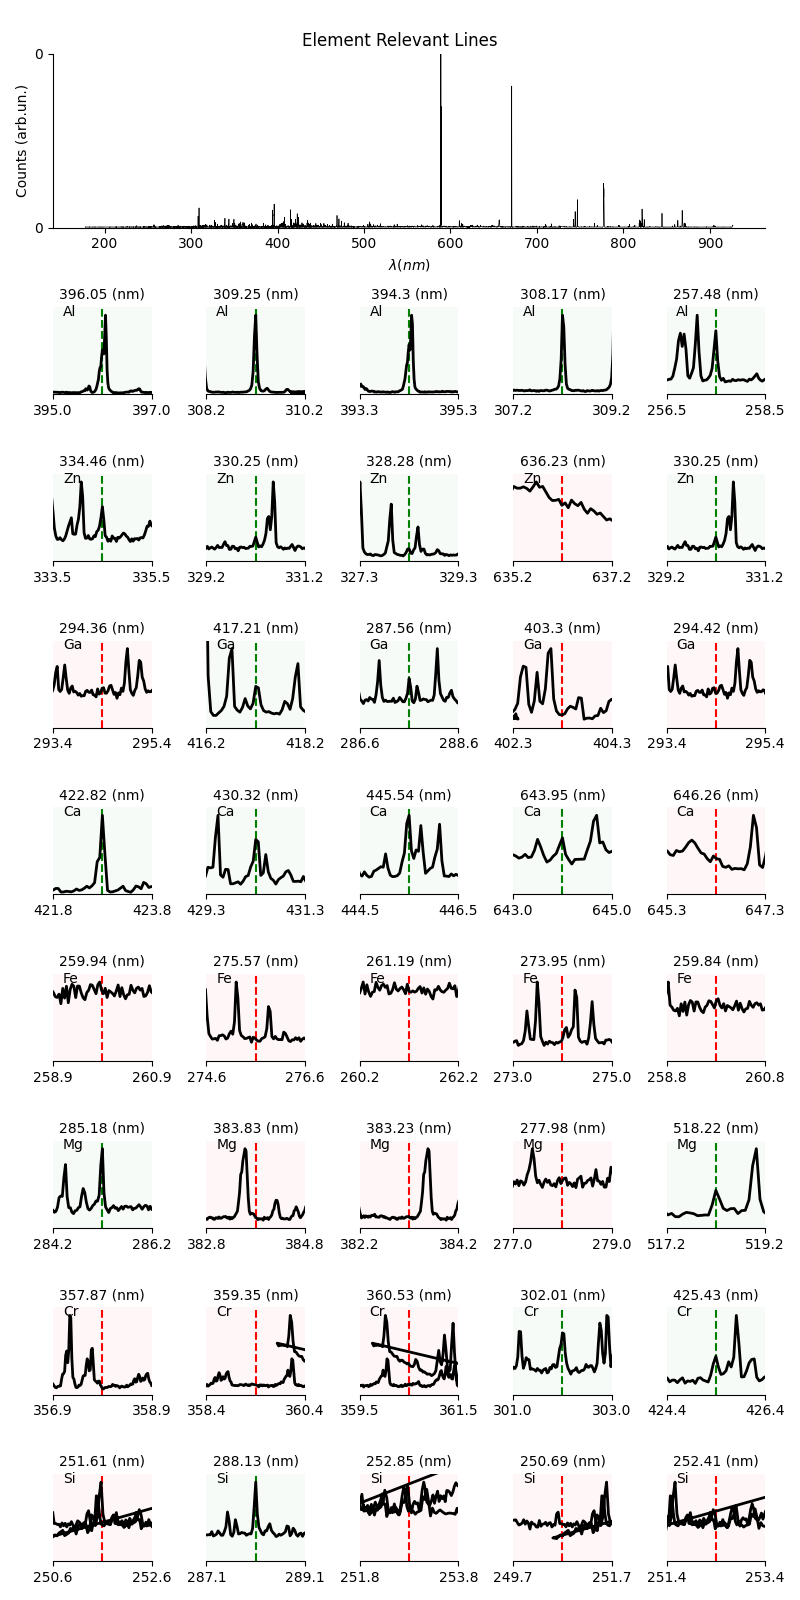

In [40]:
list_elements = ['Al', 'Zn', 'Ga', 'Ca', 'Fe', 'Mg', 'Cr', 'Si']


sample_pairs = [['Cimento XRF', cpost],
                ['Cimento Granulado', spost]]

for sample, spectrum_analysis in sample_pairs:
    wl = np.concatenate(wavelengths, axis = 0) 
    print('#############################################')
    print('Current Sample:' + sample)

    temp_spectrum = spectrum_analysis
    elements_found = []
    peaks_found = []
    peaks_not_found = []

    for i in range(0, len(list_elements)):
        element_name = list_elements[i]
        nlines = 5
        predictions, peaks, not_peaks = find_element(element_name, temp_spectrum, wl, nlines = nlines, dh1 = 0.2, peak_prominence = 0.0025)
        if element_name == 'Fe':
            predictions, peaks, not_peaks = find_element(element_name, temp_spectrum, wl, nlines = nlines, dh1 = 0.2, ion_num = 2, peak_prominence = 0.0025)
        elements_found.append(predictions)
        peaks_found.append(peaks)
        peaks_not_found.append(not_peaks)

    peaks_found = np.array(peaks_found, dtype = 'object')
    peaks_not_found = np.array(peaks_not_found, dtype = 'object')


    for i, element in enumerate(list_elements):
        if len(peaks_found[i]) > 0:
            st = [(str(np.round(peaks_found[i][j][1], 2)) +' nm') for j in range(0, len(peaks_found[i]))]
            print(element, '\t', st)


    import matplotlib.gridspec as gridspec


    fig = figure(figsize=[4*2,8*1+1*len(list_elements)], tight_layout = True)
    suptitle('Element Relevant Lines')
    gs = gridspec.GridSpec(1+len(list_elements), nlines,height_ratios =  [1]+len(list_elements)*[0.5] )

    ax1 = fig.add_subplot(gs[0,:])
    plot_spec = temp_spectrum #np.mean(pro_data,axis=(0,1))
    ax1.plot(wl, plot_spec, lw = 0.5,color='k')
    # ax1.plot(wl, FM_spectrum, lw = 0.5,color='purple')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xlabel(r'$\lambda (nm)$')
    ax1.set_ylabel(r'Counts (arb.un.)')
    ax1.set_ylim(np.min(plot_spec),np.max(plot_spec))
    ylims = ax1.get_ylim()
    ax1.set_yticks([0,ylims[1]])
    ax1.set_yticklabels([0,int(ylims[1])])


    for index_col,element_to_find in enumerate(list_elements):


        index = np.where(np.array(list_elements)==element_to_find)[0]
        lines_found = len(peaks_found[index][0])
        lines_not_found = len(peaks_not_found[index][0])

        

        ddh = 1
        for i in range(0,lines_found):
            plot_index = int(peaks_found[index][0][i][0])
            
            ax = fig.add_subplot(gs[index_col+1,plot_index])

            ax.text(0.1,0.9,element_to_find, transform=ax.transAxes)
            current_line = peaks_found[index][0][i][1]
            ax.set_title(str(np.round(current_line,2))+ ' (nm)',fontsize=10)
            
            ax.axvline(current_line,color='g',ls='--')
            
            line, = ax.plot(wl, plot_spec,lw=2,color='k',)
            ax.set_xlim(current_line-ddh,current_line+ddh)
            #autoscale
            xd = line.get_xdata()
            yd = line.get_ydata()
            lo,hi = ax.get_xlim()
            y_displayed = yd[((xd>lo) & (xd<hi))]
            ax.set_ylim(0,1.1*np.max(y_displayed))
            ax.set_yticks([])
            xlims = ax.get_xlim()
            ax.set_xticks([xlims[0],xlims[1]])
            ax.set_xticklabels([np.round(xlims[0],1),np.round(xlims[1],1)])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.patch.set_facecolor('green')
            ax.patch.set_alpha(0.03)
            
        for i in range(0,lines_not_found):
            plot_index = int(peaks_not_found[index][0][i][0])
            ax = fig.add_subplot(gs[index_col+1,plot_index])
            
            current_line = peaks_not_found[index][0][i][1]
            ax.set_title(str(np.round(current_line,2))+ ' (nm)',fontsize=10)
            ax.text(0.1,0.9,element_to_find, transform=ax.transAxes)
            
            ax.axvline(current_line,color='r',ls='--')
            
            line, = ax.plot(wl, plot_spec,lw=2,color='k',)
            ax.set_xlim(current_line-ddh,current_line+ddh)
            #autoscale
            xd = line.get_xdata()
            yd = line.get_ydata()
            lo,hi = ax.get_xlim()
            y_displayed = yd[((xd>lo) & (xd<hi))]
            ax.set_ylim(0,1.1*np.max(y_displayed))
            ax.set_yticks([])
            xlims = ax.get_xlim()
            ax.set_xticks([xlims[0],xlims[1]])
            ax.set_xticklabels([np.round(xlims[0],1),np.round(xlims[1],1)])
            
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.patch.set_facecolor('red')
            ax.patch.set_alpha(0.03)
            
        tight_layout()
    # savefig('E:Data/Data_LIBS/Vidros/Areias/Images/' + sample +'_spectral_analysis.png', dpi=200)